In [48]:
# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import numpy as np

dataroot = 'D:/Work/nuscene/data/sets/nuscenes'
nusc = NuScenes(version='v1.0-trainval', dataroot=dataroot, verbose=False)

# find a straight road for resolution determination
scene_id = 1

# load map, the corresponding map to the scene
nusc_map = NuScenesMap(dataroot=dataroot, map_name='boston-seaport')

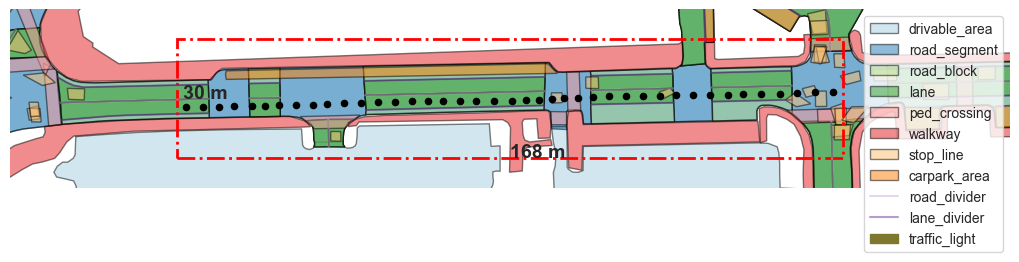

In [49]:
# get all samples in the scene
sensor = 'CAM_FRONT'
layer_names = ['road_segment', 'lane', 'ped_crossing', 'walkway', 'stop_line', 'carpark_area']
current_sample = nusc.get('sample', nusc.scene[scene_id]['first_sample_token'])
samples = []
ego_poses = nusc_map.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[scene_id]['token']], verbose=False)
while not current_sample["next"] == "":
    samples.append(current_sample)
    # Update the current sample with the next sample
    current_sample = nusc.get('sample', current_sample["next"])


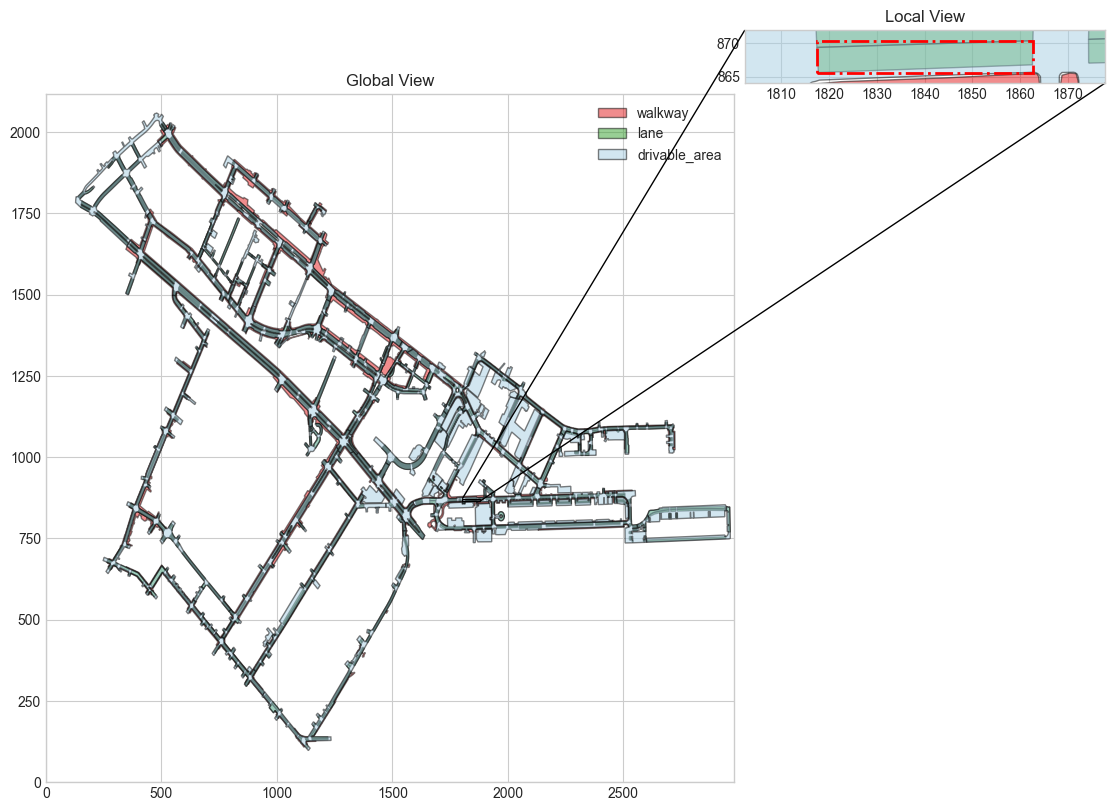

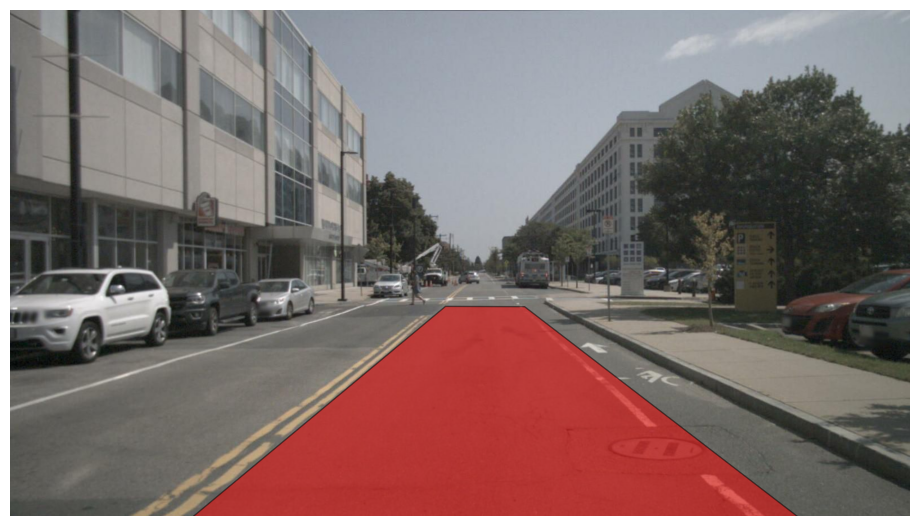

In [50]:
import descartes
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points
from shapely.geometry import Polygon
from PIL import Image
from clip_points_behind_camera import clip_points_behind_camera
from LaneDetection import LaneDetection, NuSceneProcessing

%matplotlib inline

near_plane = 1e-8
#lane_record = nusc_map.get_arcline_path(closest_lane)
current_sample = samples[509] # chose one for an example in that scene
cam_token = current_sample['data'][sensor]
cam_front_data = nusc.get('sample_data', cam_token)
ego_pos = nusc.get("ego_pose", cam_front_data["ego_pose_token"])
cs_record = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
cam_intrinsic = np.array(cs_record['camera_intrinsic'])
cam_path = nusc.get_sample_data_path(cam_token)
im = Image.open(cam_path)
im_size = im.size

scene_record = nusc.get('scene', current_sample['scene_token'])
log_record = nusc.get('log', scene_record['log_token'])
log_location = log_record['location']
assert nusc_map.map_name == log_location, \
    'Error: NuScenesMap loaded for location %s, should be %s!' % (nusc_map.map_name, log_location)

closest_lane_token = nusc_map.get_closest_lane(ego_pos['translation'][0], ego_pos['translation'][1], radius=2)
closest_lane = None
try:
    closest_lane = nusc_map.get("lane", closest_lane_token)
    nusc_map.render_record("lane", closest_lane_token)
    # nusc_map.render_map_in_image(nusc, current_sample['token'], layer_names=layer_names, camera_channel=sensor)

except KeyError as e:
    closest_lane_connector = nusc_map.get("lane_connector", closest_lane_token)

point_xy = [] # points in the real world
points_img = [] # points in the image
# we skip lane connector
if closest_lane is not None:
    poly = nusc_map.get("polygon", closest_lane['polygon_token'])

    for point in poly['exterior_node_tokens']:
        node = nusc_map.get('node', point)
        point_xy.append([node['x'], node['y']])

    polygon = Polygon(point_xy)
    point_xy = np.array(point_xy)

    # Init axes.
    fig = plt.figure(figsize=(9, 16))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, im_size[0])
    ax.set_ylim(0, im_size[1])
    ax.imshow(im)

    # Convert polygon nodes to pointcloud with 0 height.
    points = np.array(polygon.exterior.xy)
    points = np.vstack((points, np.zeros((1, points.shape[1]))))
    # Transform into the ego vehicle frame for the timestamp of the image.
    points = points - np.array(ego_pos['translation']).reshape((-1, 1))
    points = np.dot(Quaternion(ego_pos['rotation']).rotation_matrix.T, points)
    # Transform into the camera.
    points = points - np.array(cs_record['translation']).reshape((-1, 1))
    points = np.dot(Quaternion(cs_record['rotation']).rotation_matrix.T, points)

    points = clip_points_behind_camera(points, near_plane)

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(points, cam_intrinsic, normalize=True)
    points = points[:2, :]
    points = [(p0, p1) for (p0, p1) in zip(points[0], points[1])]
    polygon_proj = Polygon(points)
    label = 'LaneMarking'
    ax.add_patch(descartes.PolygonPatch(polygon_proj, fc='r', alpha=0.5,
                                        label=label))
    # Display the image.
    plt.axis('off')
    ax.invert_yaxis()
    points_img = points
    # plt.figure()
    # plt.plot(point_xy[:,0], point_xy[:,1])
# # save data to a dict
# dataset = {'front_cam': cam_front_data, 'ego_pos': ego_pos, 'closest_lane': closest_lane,
#            'closest_lane_xy': point_xy}
# data.append(dataset)

plt.show()


In [51]:
points_img

[(241441232812.43524, 185605655984.494),
 (914.8325888852537, 527.8721750762115),
 (774.2056213877418, 527.3298610649766),
 (-222324858661.41293, 185164214132.18457)]

In [52]:
from PIL import ImageDraw
img1 = ImageDraw.Draw(im)
img1.line(points_img, fill ="red", width = 0)
im.show()

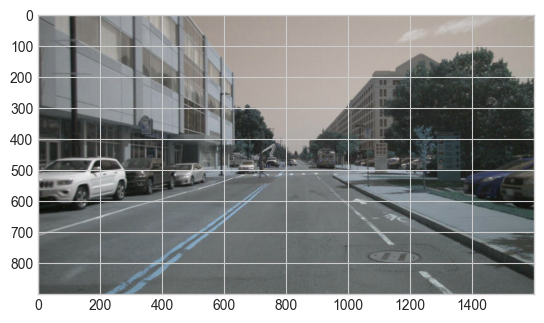

In [53]:
import cv2
color = (0, 255, 0)
thickness = 2
image = cv2.imread(cam_path)
for inx in range(1, len(points_img) - 3):
    cv2.line(image, (int(points_img[inx][0]), int(points_img[inx][1])), (int(points_img[inx+1][0]), int(points_img[inx+1][1])),
             color=color, thickness=thickness)
plt.imshow(image)

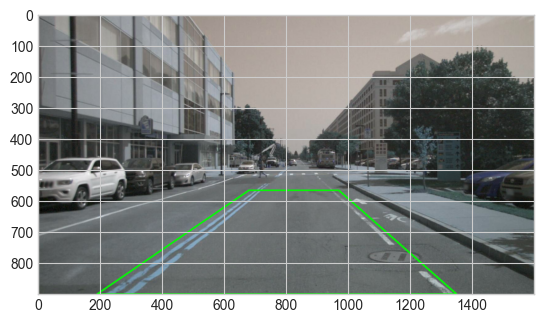

In [55]:
# transform image to perspective
import cv2
lane_detection = LaneDetection()
source_points = lane_detection.source_points
image = cv2.imread(cam_path)
img = lane_detection.draw_polygon_on_image(source_points, image)
plt.imshow(img)
plt.show()

# compute the perspective transform matrix and then apply it
# the method refers to https://github.com/Ayanzadeh93/Udacity-Advance-Lane-detection-of-the-road
M = lane_detection.M
points_in_reality = point_xy
pp = []
for p in points_img:
    persepctive_points = np.array([p[0], p[1]], dtype=float)
    point = cv2.perspectiveTransform(persepctive_points.reshape(-1, 1, 2), M)
    pp.append(point)
points_on_img = pp

In [56]:
points_in_reality

array([[1817.77948937,  865.60157866],
       [1862.59779264,  866.75049393],
       [1862.69540285,  870.34385692],
       [1817.453134  ,  869.34189587]])

In [57]:
points_on_img

[array([[[1233.30620486,  445.33333307]]]),
 array([[[1080.85300539, -221.82069973]]]),
 array([[[ 235.85289635, -226.71021267]]]),
 array([[[116.92415371, 445.33333306]]])]

In [58]:
pix_per_meter_x = abs((points_on_img[0][0][0][0]- points_on_img[3][0][0][0])/(points_in_reality[0][1] - points_in_reality[3][1]))
Lh = np.linalg.inv(np.matmul(M, cam_intrinsic))
pix_per_meter_y = pix_per_meter_x * np.linalg.norm(Lh[:,0]) / np.linalg.norm(Lh[:,1])

In [59]:
1/pix_per_meter_x

0.003350391751413032

In [60]:
1/pix_per_meter_y

0.03767551975427726

In [61]:
# the second way to calculate meter per pixel
resampled_lanes = NuSceneProcessing.resample_lane(points_in_reality)

points_num = len(resampled_lanes[0][0])
inx = int(points_num/2)
interval = 5

left_x = [resampled_lanes[0][0][inx+interval]]
left_y = [resampled_lanes[0][1][inx+interval]]

right_x = [resampled_lanes[1][0][points_num - inx-interval]]
right_y = [resampled_lanes[1][1][points_num - inx-interval]]

selected_resamples = [np.array([left_x, left_y]), np.array([right_x, right_y])]

selected_resamples_pixle = LaneDetection.world2pixel(selected_resamples, cs_record, ego_pos)

TypeError: get_lane_on_map() missing 1 required positional argument: 'ego_pos'

In [ ]:
from utils import plot_lane_on_map
image = cv2.imread(cam_path)
plot_lane_on_map(image, [], selected_resamples_pixle)


In [ ]:
pps = []
for p in selected_resamples_pixle:
    persepctive_points = np.array([p[0], p[1]], dtype=float)
    point = cv2.perspectiveTransform(persepctive_points.reshape(-1, 1, 2), M)
    pps.append(point)
pps


In [ ]:
(left_x[0] - right_x[0]) / (pps[0][0][0][1] - pps[1][0][0][1])

In [ ]:
(left_y[0] - right_y[0]) / (pps[0][0][0][0] - pps[1][0][0][0])

In [ ]:
pps[0][0][0][1] - pps[1][0][0][1]